### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [1]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

== Conda 环境检查报告 (仅针对当前 Bash 子进程) ==
✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。
✅ 正在使用的环境路径: /workspace/envs/flyai_agent_in_action

💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。
   如果需要后续单元格也使用此环境，请执行以下操作:
   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。


In [2]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


Writing to /root/.config/pip/pip.conf
Note: you may need to restart the kernel to use updated packages.
global.index-url='https://pypi.tuna.tsinghua.edu.cn/simple'
:env:.target=''
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

env: HF_ENDPOINT=https://hf-mirror.com
https://hf-mirror.com


In [4]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
### 环境信息
| 项目         | 信息                                                                  |
|:-------------|:----------------------------------------------------------------------|
| 操作系统     | Linux 5.15.0-126-generic                                              |
| CPU 信息     | Intel(R) Xeon(R) Platinum 8468 (48 physical cores, 192 logical cores) |
| 内存信息     | 2015.36 GB (Available: 1868.40 GB)                                    |
| GPU 信息     | No GPU found (checked nvidia-smi, lshw not found)                     |
| CUDA 信息    | 12.6                                                                  |
| Python 版本  | 3.12.11                                                               |
| Conda 版本   | conda 25.7.0                                                          |
| 物理磁盘空间 | Total: 2014.78 GB, Used: 788.88 GB, Free: 1123.48 GB                  |


# 路由器模式 (Router Pattern)

## 什么是路由器模式？

路由器模式是LangGraph中的一个核心概念，它允许大语言模型根据用户输入智能地决定下一步行动：
- **直接回复**：当用户的问题不需要工具时，直接生成自然语言回复
- **调用工具**：当用户的问题需要计算、查询或处理时，调用相应的工具

这种模式是构建智能代理（Agent）的基础，让AI能够像人类一样思考和行动。

## 回顾与目标

### 回顾
在前面的学习中，我们构建了一个使用 `messages` 作为状态的图，并集成了带有绑定工具的聊天模型。

我们发现这个图可以：
* **返回工具调用**：当需要执行特定操作时
* **返回自然语言回复**：当可以直接回答用户问题时

### 学习目标
我们可以将这个图理解为一个**路由器**，其中聊天模型根据用户输入在直接回复和工具调用之间进行路由选择。

这是智能代理（Agent）的一个简单示例，其中大语言模型通过调用工具或直接回复来指导控制流程。

![路由器模式示意图](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

让我们扩展我们的图，使其能够处理两种输出！

为此，我们需要使用两个核心概念：

1. **添加工具调用节点**：专门用于执行我们的工具
2. **添加条件边**：检查聊天模型的输出，并路由到工具调用节点或在没有工具调用时直接结束



In [5]:
# 安装必要的依赖包
# 这些包是构建LangGraph应用的核心组件
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 langgraph-prebuilt==0.6.4

Note: you may need to restart the kernel to use updated packages.


In [6]:
# 环境变量设置
# 设置OpenAI API密钥，这是使用OpenAI模型的前提条件
import os, getpass

def _set_env(var: str):
    """
    安全地设置环境变量
    如果环境变量不存在，则提示用户输入
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置OpenAI API密钥
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY:  ········
OPENAI_BASE_URL:  ········


In [7]:
# 导入必要的模块
from langchain_openai import ChatOpenAI

# 定义工具函数
def multiply(a: int, b: int) -> int:
    """
    乘法工具函数
    这是一个简单的数学计算工具，用于演示工具调用机制

    Args:
        a: 第一个整数
        b: 第二个整数

    Returns:
        int: 两个整数的乘积
    """
    return a * b

# 初始化大语言模型
# 使用GPT-4o模型，这是OpenAI最新的多模态模型
llm = ChatOpenAI(model="gpt-4o")

# 将工具绑定到语言模型
# 这样模型就可以在需要时调用我们定义的工具
llm_with_tools = llm.bind_tools([multiply])

## 核心组件说明

我们使用LangGraph提供的两个内置组件来构建路由器：

1. **[内置 `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode)**：
   - 专门用于执行工具调用的节点
   - 只需要传入工具列表即可初始化
   - 自动处理工具的执行和结果返回

2. **[内置 `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition)**：
   - 作为条件边的判断函数
   - 检查模型输出是否包含工具调用
   - 根据检查结果决定下一步的路由方向

In [8]:
# 导入必要的模块
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# 定义工具调用节点
def tool_calling_llm(state: MessagesState):
    """
    工具调用节点函数
    这个节点负责调用带有工具的大语言模型

    Args:
        state: 包含消息列表的状态对象

    Returns:
        包含模型响应的新状态
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 构建LangGraph图
print("正在构建路由器图...")

# 创建状态图构建器，使用MessagesState作为状态类型
builder = StateGraph(MessagesState)

# 添加节点
# 1. 工具调用节点：负责调用大语言模型
builder.add_node("tool_calling_llm", tool_calling_llm)

# 2. 工具执行节点：负责执行具体的工具
builder.add_node("tools", ToolNode([multiply]))

# 添加边（连接）
# 从开始节点到工具调用节点
builder.add_edge(START, "tool_calling_llm")

# 添加条件边：从工具调用节点根据条件路由
builder.add_conditional_edges(
    "tool_calling_llm",
    # 条件判断逻辑：
    # - 如果助手的最新消息是工具调用 -> tools_condition 路由到 tools 节点
    # - 如果助手的最新消息不是工具调用 -> tools_condition 路由到 END 节点
    tools_condition,
)

# 从工具节点到结束节点
builder.add_edge("tools", END)

# 编译图
graph = builder.compile()

print("图构建完成！")


正在构建路由器图...
图构建完成！


路由器图结构：
图可视化：


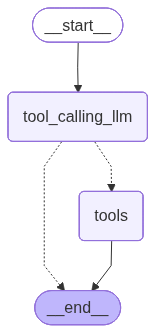

✅ 图渲染成功！


In [9]:
# 图可视化
print("路由器图结构：")
print("图可视化：")

# 方案1：尝试使用 Pyppeteer 本地渲染（推荐）
try:
    # 可视化：通过 Mermaid 渲染图结构
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("✅ 图渲染成功！")
except Exception as e:
    print(f"❌ Pyppeteer 渲染失败: {e}")
    
    # 方案2：显示 Mermaid 文本格式
    print("\n📝 图结构（Mermaid 文本格式）：")
    print("=" * 50)
    mermaid_text = graph.get_graph().draw_mermaid()
    print(mermaid_text)
    print("=" * 50)
    
    # 方案3：显示图的节点和边信息
    print("\n🔗 图结构信息：")
    print("节点:", list(graph.get_graph().nodes.keys()))
    print("边:", list(graph.get_graph().edges))
    
    # 方案4：提供手动渲染说明
    print("\n💡 手动渲染说明：")
    print("1. 复制上面的 Mermaid 文本")
    print("2. 访问 https://mermaid.live/")
    print("3. 粘贴文本到编辑器中查看图形")
    print("4. 或者使用支持 Mermaid 的 Markdown 编辑器")


In [11]:
# 测试路由器功能
from langchain_core.messages import HumanMessage

print("=" * 50)
print("测试1：需要工具调用的数学问题")
print("=" * 50)

# 创建一个需要工具调用的问题
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]

# 调用图进行推理
print("正在处理用户问题...")
result = graph.invoke({"messages": messages})

# 显示所有消息（包括用户问题、模型响应、工具调用和工具结果）
print("\n对话流程：")
for i, m in enumerate(result['messages']):
    print(f"\n步骤 {i+1}:")
    m.pretty_print()

测试1：需要工具调用的数学问题
正在处理用户问题...

对话流程：

步骤 1:
================================ Human Message =================================

Hello, what is 2 multiplied by 2?

步骤 2:
================================== Ai Message ==================================
Tool Calls:
  multiply (call_CSfexONIjqIQi3QvYFhbsCAi)
 Call ID: call_CSfexONIjqIQi3QvYFhbsCAi
  Args:
    a: 2
    b: 2

步骤 3:
================================= Tool Message =================================
Name: multiply

4


In [12]:
# 测试路由器功能
from langchain_core.messages import HumanMessage

print("=" * 50)
print("测试2：不需要工具调用的数学问题")
print("=" * 50)

# 创建一个需要工具调用的问题
messages = [HumanMessage(content="解释LangGraph中的路由器模式")]

# 调用图进行推理
print("正在处理用户问题...")
result = graph.invoke({"messages": messages})

# 显示所有消息（包括用户问题、模型响应、工具调用和工具结果）
print("\n对话流程：")
for i, m in enumerate(result['messages']):
    print(f"\n步骤 {i+1}:")
    m.pretty_print()

测试2：不需要工具调用的数学问题
正在处理用户问题...

对话流程：

步骤 1:
================================ Human Message =================================

解释LangGraph中的路由器模式

步骤 2:
================================== Ai Message ==================================

在LangGraph中，路由器模式是一种用于控制和管理数据流的设计模式。这种模式通常用于处理复杂的决策逻辑、任务分配以及路径选择等场景。通过将不同的处理逻辑或操作路径封装在单独的路由器中，可以提高系统的可扩展性和可维护性。

### 路由器模式的核心概念

1. **决策节点**：路由器根据输入的数据或事件触发不同的处理路径。这些决策通常基于预定义的条件或业务逻辑。

2. **灵活性和可扩展性**：路由器模式允许系统的不同部分独立演化和扩展，而不需要对整个系统进行大规模的重构。

3. **模块化**：通过将复杂的逻辑分解为独立的路由器，可以更容易地测试、维护和理解系统的行为。

4. **负载均衡**：在处理分布式系统中的任务时，路由器可以实现负载均衡，将任务合理分配到不同的处理单元上。

5. **动态调整**：路由器可以根据实时的系统状态或环境变化动态调整路径，提供更好的性能和响应能力。

### 应用场景

- **微服务架构**：在微服务中，将请求路由到不同的服务实例上，并实现跨服务的通信。
- **数据管道**：在大数据处理工作流中，通过路由器来控制数据的流动和处理路径。
- **事件驱动系统**：管理事件的传递和动作触发，确保事件能有效触发相应的反应。

总之，路由器模式通过实现灵活且高效的路径控制，成为处理复杂系统中多个流程和操作的关键设计工具之一。


## 测试结果分析

现在我们可以看到图成功运行了工具！

它返回了一个 `ToolMessage`，这表明：
1. **模型识别**：大语言模型识别出这是一个需要计算的数学问题
2. **工具调用**：模型决定调用 `multiply` 工具
3. **工具执行**：`ToolNode` 执行了乘法计算
4. **结果返回**：工具执行结果被包装成 `ToolMessage` 返回


## 学习总结

### 路由器模式的核心概念

通过这个示例，我们学习了路由器模式的关键概念：

1. **状态管理**：使用 `MessagesState` 来管理对话历史
2. **节点设计**：
   - `tool_calling_llm`：负责调用大语言模型
   - `tools`：负责执行具体工具
3. **条件路由**：使用 `tools_condition` 根据模型输出决定下一步
4. **工具绑定**：使用 `bind_tools()` 将工具绑定到模型

### 实际应用场景

路由器模式在实际应用中有广泛用途：

- **智能客服**：根据用户问题类型路由到不同的处理模块
- **代码助手**：根据编程问题决定是否调用代码执行工具
- **数据分析**：根据查询类型决定是否调用数据处理工具
- **多模态应用**：根据输入类型决定是否调用图像或音频处理工具

### 下一步学习

掌握了路由器模式后，您可以继续学习：
- 更复杂的多工具路由
- 状态管理和持久化
- 错误处理和重试机制
- 与外部系统的集成
